In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
import copy

<h1>Please run the run mode11 and run model2 in the last cell</h2>

In [7]:
def DataCleaning(train):
    """Take Dataset clean it and return it back"""
    print("CLEANING STARTED.........")
    clipped_y  =[]
    [clipped_y.append(130) if i>180 else clipped_y.append(i) for i in train['y']]
    train['y'] = clipped_y
    actual_y = train["y"]
    train.drop("y",inplace=True,axis=1)
    print("CLEANING DONE.........")
    return [train,actual_y]
    
def Label_encoding_function(train,test):
    """Take Dataset decompose it and concatenate it with original data and return it back"""
    print("LABEL ENCODING STARTED.........")
    for c in train.columns:
        if c in ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']:
            lbl = LabelEncoder()
            lbl.fit(list(train[c].values)+ list(test[c].values))
            train[c] = lbl.transform(list(train[c].values))
            test[c] = lbl.transform(list(test[c].values))
            # Fixing the type of the coloumns
    columns = train.columns
    train[columns] = train[columns].apply(pd.to_numeric)
    test[columns] = test[columns].apply(pd.to_numeric)
    print("LABEL ENCODING DONE.........")
    return [train,test]

def decomposed_features(train_,test_):
    n_comp = 12
    print("DECOMPOSITION STARTED.........")
    # tSVD
    tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
    tsvd_results_train = tsvd.fit_transform(train_)
    tsvd_results_test = tsvd.transform(test_)

    # PCA
    pca = PCA(n_components=n_comp, random_state=420)
    pca2_results_train = pca.fit_transform(train_)
    pca2_results_test = pca.transform(test_)

    # ICA
    ica = FastICA(n_components=n_comp, random_state=420)
    ica2_results_train = ica.fit_transform(train_)
    ica2_results_test = ica.transform(test_)

    # GRP
    grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
    grp_results_train = grp.fit_transform(train_)
    grp_results_test = grp.transform(test_)

    # SRP
    srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
    srp_results_train = srp.fit_transform(train_)
    srp_results_test = srp.transform(test_)                                

    #save columns list before adding the decomposition components

    usable_columns = list(set(train_.columns) - set(['y']))

    # Append decomposition components to datasets
    for i in range(1, n_comp + 1):
        train_['pca_' + str(i)] = pca2_results_train[:, i - 1]
        test_['pca_' + str(i)] = pca2_results_test[:, i - 1]

        train_['ica_' + str(i)] = ica2_results_train[:, i - 1]
        test_['ica_' + str(i)] = ica2_results_test[:, i - 1]

        train_['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
        test_['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

        train_['grp_' + str(i)] = grp_results_train[:, i - 1]
        test_['grp_' + str(i)] = grp_results_test[:, i - 1]

        train_['srp_' + str(i)] = srp_results_train[:, i - 1]
        test_['srp_' + str(i)] = srp_results_test[:, i - 1]
    print("DECOMPOSITION DONE.........")    
    return [train_,test_]

class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))
        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed
    
def Training(train,test):
    '''                     DATA CLEANING                  
    '''
    Data = DataCleaning(train)
    train = Data[0]
    actual_y = Data[1]
    '''                     DATA DECOMPOSING                  
    '''
    b = Label_encoding_function(train,test)
    train = b[0]
    test = b[1]
    # creating a deep copy and calling decompose function
    decomposed_train = copy.deepcopy(train)
    decomposed_test= copy.deepcopy(test)
    decomposed_train,decomposed_test = decomposed_features(decomposed_train,decomposed_test)
    
    
    '''                      MODEL ARCHITECTURE                  
                    Train the xgb model then predict the test data
    '''
    xgb_params = {'n_trees': 520,'eta': 0.0045,'max_depth': 4,'subsample': 0.93,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1}
    dtrain = xgb.DMatrix(decomposed_train, actual_y)
    dtest = xgb.DMatrix(decomposed_test)
    # NOTE: Make sure that the class is labeled 'class' in the data file
    num_boost_rounds = 1250
    # train model
    print("TRAINING STARTED")
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
    
    # Pipeline of the model
    stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True,cv=5)),
    StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,learning_rate=0.1,\
                          loss='ls', max_depth=3,max_features=0.55, max_leaf_nodes=None,\
                          min_impurity_decrease=0.0, min_impurity_split=None,\
                          min_samples_leaf=14, min_samples_split=16,\
                          min_weight_fraction_leaf=0.0, n_estimators=100,\
                          n_iter_no_change=None, presort='auto',\
                          random_state=19, subsample=0.8, tol=0.0001,\
                          validation_fraction=0.1, verbose=0, warm_start=False)),
    LassoLarsCV(normalize=True,cv=5)
)

    stacked_pipeline.fit(train, actual_y)
    print("TRAINING DONE")
    return [model,stacked_pipeline,actual_y,dtest,dtrain]

In [10]:
def MercedesGrennerFunction1(train,test):
    '''                     THIS FUNCTION RETURNS TEST PREDICTION
    '''
    models = Training(train,test)
    model = models[0]
    stacked_pipeline = models[1]
    actual_y = models[2]
    dtest = models[3]
    
    y_pred = model.predict(dtest)
    results = stacked_pipeline.predict(test)
    '''R2 Score on the entire Train data when averaging'''
    i = .62
    '''Average the preditionon test data  of both models then save it on a csv file'''
    sub = pd.DataFrame()
    prediction = y_pred*(1-i) + results*i
    return prediction


def MercedesGrennerFunction2(train,test):
    '''                     THIS FUNCTION RETURNS TRAIN PREDICTION
    '''
    models = Training(train,test)
    model = models[0]
    stacked_pipeline = models[1]
    actual_y = models[2]
    dtrain = models[4]
    i = .62
    prediction = stacked_pipeline.predict(train)*i + model.predict(dtrain)*(1-i)
    return prediction 

CLEANING STARTED.........
CLEANING DONE.........
LABEL ENCODING STARTED.........
LABEL ENCODING DONE.........
DECOMPOSITION STARTED.........
DECOMPOSITION DONE.........
TRAINING STARTED
[23:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAINING DONE


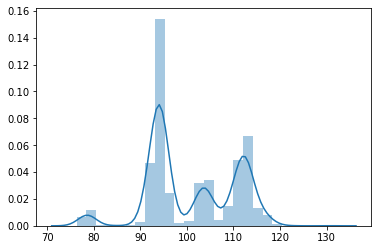

In [5]:
def RunModel1():
    '''                     THIS FUNCTION RETURNS TEST PREDICTION
    '''
    train = pd.read_csv("./train/train.csv")
    test = pd.read_csv("./test/test.csv")
    prediction = MercedesGrennerFunction1(train,test)
    sns.distplot(prediction)
    plt.show()
RunModel1()    

CLEANING STARTED.........
CLEANING DONE.........
LABEL ENCODING STARTED.........
LABEL ENCODING DONE.........
DECOMPOSITION STARTED.........
DECOMPOSITION DONE.........
TRAINING STARTED
[23:41:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAINING DONE


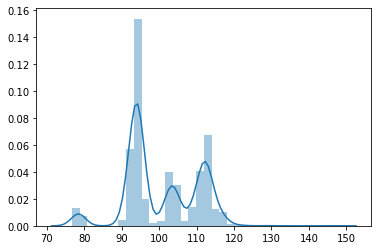

In [11]:
def RunModel2():
    '''                     THIS FUNCTION RETURNS TRAIN PREDICTION
    '''
    train = pd.read_csv("./train/train.csv")
    test = pd.read_csv("./test/test.csv")
    prediction = MercedesGrennerFunction2(train,test)
    sns.distplot(prediction)
    plt.show()
RunModel2()    